# Introduction
1. To create a model to classify of 3 stages (Tinh thuc/buon ngu/deep sleep) based on 6 data from an acccelerometer which placed on a subject's head while sleeping on bed.
2. Some knowledge: 1 giac ngu: Tinh thuc, chuyen tiep (N1), ngu (N2), ngu sau (N3) and giac ngu cu dong mat nhanh (REM)
3. Data were processed and splited to: Train and Test which are 300MB of total.
4. Each folder Train/Test contain 6 files coressponding to 6 data from X, Y, Z of accelerometer and gyroscope. Each file is a column vector of 300 length.
5. The goal of this TUT is to practice the classification of multi-labels on serial data by applying 5 different models as the following:

    a. LSTM
    
    b. CNN 1D
    
    c. CNN 1D with multi-read input
    
    d. CNN 1D & LSTM
    
    e. CNN 2D & LSTM


In [2]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from keras.utils import to_categorical

Using TensorFlow backend.


# Step 1 : Data preparation

In [4]:
# upload a file data, then put it to numpy array
def load_file(filepath):
    dataframe = read_csv(filepath, header = None)
    return dataframe.values

In [13]:
# dowload many files after that all data are combined to 3D array
def load_group(filenames, prefix = 'Sleep Class/Sleep Class/'):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = dstack(loaded)
    return loaded

Group: Train or Test

Prefix is the path of folder which contains train/test data. Filepath: prefix + group + '/Signals'

Filenames are lists created for AX, AY, AZ and GX, GY, GZ. X --> 3D array as features and y is 1D array for output

In [14]:
def load_dataset_group(group, prefix = 'Sleep Class/Sleep Class/'):
    filepath = prefix + group + '/Signals/'
    filenames = list()
    filenames += ['AX_'+group+'.txt','AY_'+group+'.txt','AZ_'+group+'.txt']
    filenames += ['GX_'+group+'.txt','GY_'+group+'.txt','GZ_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/Y_'+group+'.txt')
    return X, y

In [16]:
# Create 3D array for X_train and X_test and 1D array for Y_train and Y_test
def load_dataset(prefix = 'Sleep Class/Sleep Class/'):
    # Features for Train
    trainX, trainy = load_dataset_group('train', prefix + './')
    # Features for Test
    testX, testy = load_dataset_group('test', prefix + './')
    # Onhot coding for labels of output Y
    trainy = to_categorical(trainy)
    testy = to_categorical(testy)
    return trainX, trainy, testX, testy

In [60]:
trainX, trainy, testX, testy = load_dataset()

In [53]:
trainX.shape[0]

10408

In [42]:
trainX[10407, 298, 5]

0.21857401025641002

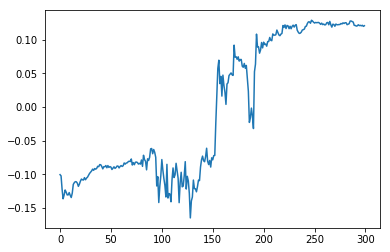

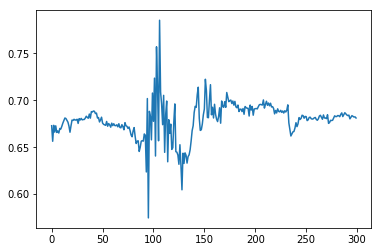

In [50]:
trainX[0,:,0]
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(trainX[0,:,0])
plt.figure(2)
plt.plot(trainX[0,:,1])
plt.show()

In [24]:
trainy.shape

(10408, 5)

In [71]:
trainX[0,150,0]

-0.07849149999999999

In [69]:
cut = int(trainX.shape[1] / 2)
cut
longX = trainX[:,-cut:, :]
longX[0,:,0]

array([-0.0784915 , -0.07226533, -0.0719605 , -0.02433267,  0.014465  ,
        0.05729167,  0.0695495 ,  0.034729  ,  0.045532  ,  0.01619467,
        0.047394  ,  0.03204367,  0.0219725 ,  0.003906  ,  0.03411875,
        0.03607167,  0.046753  ,  0.04874667,  0.050629  ,  0.047882  ,
        0.04691533,  0.091919  ,  0.07395433,  0.074646  ,  0.07086167,
        0.0746155 ,  0.06819667,  0.0704955 ,  0.07061767,  0.0606385 ,
        0.05904133,  0.064728  ,  0.057556  ,  0.061737  ,  0.04219567,
        0.02333567, -0.022929  , -0.015747  , -0.00162767, -0.013611  ,
       -0.0320125 ,  0.05240867,  0.0637815 ,  0.10827633,  0.0891415 ,
        0.089274  ,  0.0799865 ,  0.08487967,  0.0958555 ,  0.08785   ,
        0.0963135 ,  0.092875  ,  0.0936585 ,  0.09037267,  0.09720867,
        0.09731033,  0.103333  ,  0.09916167,  0.098511  ,  0.108541  ,
        0.107025  ,  0.10668967,  0.107422  ,  0.1143495 ,  0.11081933,
        0.1071165 ,  0.10597733,  0.1083065 ,  0.10935467,  0.12

## Standaize process includes 4 steps:
1. Remove same values in trainX file, then label new data to object longX
2. Replace time window (currently 300 samples) to 1D vector by using reshape function. 3D arry of trainX and testX is converted to 2D arrays with the first dimention equaling the number of time Window ( 1st dimention of arrayX = 10408) and the second one is the number of features (6 signals).
3. Using module preprocessing to standardize for 2D arraays, namely flatTrainX and flatTestX
4. Recover the structure of data of 3D arrays as the beginning.

In [57]:
# standardize the data

from sklearn.preprocessing import StandardScaler
def scale_data(trainX, testX, standardize):
    # Step 1: remove same values
    cut = int(trainX.shape[1] / 2)
    longX = trainX[:,-cut:, :] # take last 150 values of each window
    longX.shape
    # Step 2: move the window to a vector
    longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
    # Step 3: Move train and test to a vector
    flatTrainX = trainX.reshape((trainX.shape[0] * trainX.shape[1], trainX.shape[2]))
    flatTestX = testX.reshape((testX.shape[0] * testX.shape[1], testX.shape[2]))
    # Standardize
    if standardize:
        s = StandardScaler()
        # fit on training data
        s.fit(longX)
        # apply to training and test data
        longX = s.transform(longX)
        flatTrainX = s.transform(flatTrainX)
        flatTestX = s.transform(flatTestX)
    # Recover data to 3D
    flatTrainX = flatTrainX.reshape((trainX.shape))
    flatTestX = flatTestX.reshape((testX.shape))
    return flatTrainX, flatTestX, longX.shape

In [63]:
S_train, S_testX, longX_size = scale_data(trainX, testX, standardize = True)

In [62]:
longX_size

(1561200, 6)

# Build models

## First model: LSTM

For LSTM, each layer requires the input data with 3D array and the second dimension should be the size of window and the third one is the number of feature. 

In [73]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [74]:
n_timesteps

300

In [75]:
n_outputs

5

In [76]:
n_features

6

In [78]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(128, input_shape = (n_timesteps, n_features)))
# The number of parameters in LSTM layer: 4*[(n_features +1)* no.Unit + no.Unit^2]
# 4*[(6 + 1)*128 + 128^2] = 69120
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(n_outputs, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               69120     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 77,701
Trainable params: 77,701
Non-trainable params: 0
_________________________________________________________________
